# CSS Lab: Online Experiments
This notebook is a working example of how to analyze online experiments.
The lab uses a social influence experiment modeled after (SDW2006).
The original experiment measured the popularity of songs, but the analysis can be done for any kind of cultural artifact.

## Contents
1. [Background](#Section-1%3A-Background)
1. [Setup](#Section-2%3A-Setup)
    * [2.1 Load Python Libraries](#2.1-Load-Python-Libraries)
    * [2.2 Load Data](#2.2-Load-Data)
1. [Gini Coefficient](#Section-3%3A-Gini-Coefficient)
1. [Experiment](#Section-4%3A-Experiment)
    * [4.1 Descriptive Statistics](#4.1-Descriptive-Statistics)
    * [4.2 Gini Coefficient](#4.2-Gini-Coefficient)
    * [4.3 Market Share](#4.3-Market-Share)
    * [4.4 Unpredictability](#4.4-Unpredictability)
1. [Reflection](#Section-5%3A-Reflection)
2. [References](#References)

## Section 1: Background

The Music Lab experiment conducted by Salganik, Dodds, and Watts (SDW2006) studied the effects of social influence by observing the music listening behavior of participants.
Participants were given a list of songs and allowed to download the ones they liked to listen to later (this was before music streaming was popular). The number of downloads can be a measure of the quality of a song, but it can also result in social influence.

The experiment included a single **control** scenario where a group of participants were shown a set of **previously unknown songs from unknown bands** in an randomly ordered grid and were asked to listen, rate, and if they wanted to, download the songs. In order to measure the effect of social influence, the scientists created 8 separate scenarios (or worlds) where  **randomly assigned** participants were shown the number of times each song had been downloaded up to the point of observation. In fact, two versions of the experiment were conducted with different degrees of social influence. In the low-influence scenario, the participants were shown the songs in a grid identical to the control scenario except for the additionally showing the number of times each song was downloaded. In the  high-influence scenario participants were shown the songs in a single column in descending order of the number of downloads. 

The observations from the experiments were used to answer the two main questions: (1) How did social influence affect the popularity of the songs in comparison to the control scenario? and (2) How did social influence change the predictability of the popularity of songs in comparison to the control scenario?

In the rest of the notebook, we will replicate the analyses in the paper using the data from the experiments and interpret the findings.

## Section 2: Setup
### 2.1 Load Python Libraries
We will use several python libraries that make it easier to analyze and plot data.

In [123]:
# Initialization
%pylab inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import scipy.special as spspec
import plotnine
from plotnine import *
import warnings
warnings. filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


/Users/dmal/anaconda/envs/py37/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['arrow', 'xlim', 'annotate', 'ylim']
`%matplotlib` prevents importing * from pylab and numpy


### 2.2 Load Data
Now we'll define helper functions to read data from either the original experiment.

In [2]:
# Helper functions

# Class to manipulate data from original SDW2006 eperiment
class SDWData(object):
    def __init__(self, path="external/CW", independent_world=9, num_worlds=9, num_songs=48):
        self.path = path
        self.independent_world = independent_world
        self.num_worlds = num_worlds
        self.num_songs = num_songs
        
    # Get a DataFrame with world_id and song_id columns
    def get_world_song(self, world=None):
        df_sdw = self.get_sdw(world)
        return self.sdw_to_world_song(df_sdw)
    
    # Load the relevant data from the original experiment
    def get_sdw(self, world=None):
        # Load data from SDW experiment 1
        # Load all worlds if world is None
        downloads_file = "{path}/musiclab_data/dynamics_downloads_download_w{world}_v{experiment}.txt"
        song_ids = range(1,self.num_songs+1)
        if world is None:
            world_ids = range(1, self.num_worlds+1)
        else:
            world_ids = [world]
        columns = ['user_id', 'world_id'] \
            + ["dl_{i}".format(i=i) for i in song_ids] \
            + ['timestamp']
        df_raw = pd.concat([
            pd.read_csv(
                downloads_file.format(path=self.path, world=w, experiment=1),
                comment="%",
                header=None,
                names=columns
            )
            for w in world_ids])
        return df_raw

    # Convert SDW2006 data to a more usable format
    def sdw_to_world_song(self, df_raw):
        col_world_id = []
        col_song_id = []
        col_count = []
        song_ids = range(1,self.num_songs + 1)
        world_ids = range(1,self.num_worlds + 1)
        # Get list of world ids present in df_raw
        world_ids = sorted(set(df_raw["world_id"]))
        for cur_world in world_ids:
            # Filter by world
            df_world = df_raw[df_raw["world_id"] == cur_world]
            for cur_song in song_ids:
                col_world_id.append(cur_world)
                col_song_id.append(cur_song)
                count = df_world["dl_{}".format(cur_song)].sum()
                col_count.append(count)
        df_downloads = pd.DataFrame({
            "world_id": col_world_id,
            "song_id": col_song_id,
            "download_count": col_count,
            "rating_count": 0.0,
            "mean_rating": 0.0
        })
        return df_downloads
    
    # Generate a DataFrame with 
    def sample_independent(self, num_worlds=2):
        df_sdw = self.get_sdw(self.independent_world)
        df_sdw["world_id"] = np.random.randint(0, num_worlds, len(df_sdw.index))
        return self.sdw_to_world_song(df_sdw)

In the Salganik, Dodds, and Watts experiment [SDW2006], participants were assigned to 1 of 9 worlds. The first 8 worlds were "social influence" world, allowing participants to see the number of downloads for each song (within their world). The 9th world was a non-influence world, where participants had no info about download count.

The next cell will read in the data from the original experiment and display the first few rows. Each row represents the performance of one song in one world, identified by `song_id` and `world_id`. The other most relevant column is `download_count`, which counts how many participants in that world dowloaded the song.

We have included some of the data from the original experiment in this lab. To get the full set of data and documentation ftom that study, go to [http://opr.princeton.edu/archive/cm/](http://opr.princeton.edu/archive/cm/).

In [3]:
data = SDWData(path="external/CM", independent_world=9, num_worlds=9, num_songs=48)
df_world_song = data.get_world_song()
df_downloads = df_world_song
df_world_song.head()

,world_id,song_id,download_count,rating_count,mean_rating
0,1,1,15,0.0,0.0
1,1,2,18,0.0,0.0
2,1,3,7,0.0,0.0
3,1,4,11,0.0,0.0
4,1,5,9,0.0,0.0


## Section 3: Gini Coefficient
The [Gini coefficient](https://en.wikipedia.org/wiki/Gini_coefficient) is a meaure of how unequally a quantity such as wealth is distributed. A Gini value of 0 corresponds to a completely equal distribution, while a value of 1 corresponds to a single entity having the entire quantity while all others have nothing.

We can use the Gini coefficient to quantify how equally downloads, views, or ratings are distributed between songs (or other cultural artifacts) in the cultural market experiment.

First we define some helper functions.

In [135]:
# Helper functions

def gini(x):
    '''Given a list of counts `x`, return the gini coefficient.'''
    x = [xi for xi in x if not np.isnan(xi)]
    n = len(x)
    gini_num = sum([sum([abs(x_i - x_j) for x_j in x]) for x_i in x])
    gini_den = 2.0 * n * sum(x)
    return gini_num / gini_den

def gini_bootstrap(x, samples=1000):
    '''Given a list of counts `x`, return gini estimate and (bootstrap) standard error.'''
    x_all = list(x)
    n = len(x_all)
    num_estimates = []
    den_estimates = []
    for bootstrap_i in range(samples):
        bootstrap = [x_all[random.randint(0, len(x_all) - 1)] for x in x_all]
        gini_num = sum([sum([abs(x_i - x_j) for x_j in bootstrap]) for x_i in bootstrap])
        gini_den = 2.0 * (n - 1) * sum([x_i for x_i in bootstrap])
        num_estimates.append(gini_num)
        den_estimates.append(gini_den)
    num_mean_sq = sum([est**2 for est in num_estimates]) / len(num_estimates)
    num_mean = sum(num_estimates) / len(num_estimates)
    den_mean = sum(den_estimates) / len(den_estimates)
    num_var = num_mean_sq - (num_mean)**2
    gini = num_mean / den_mean
    gini_se = math.sqrt(num_var) / den_mean
    return gini, gini_se
    
def get_world_gini(df_world_song):
    world_ids = sorted(set(df_world_song["world_id"]))
    df_worlds = pd.DataFrame({"world_id": world_ids}).set_index("world_id")
    world_gini = [
        gini_bootstrap(df_downloads.loc[df_downloads["world_id"] == cur_world, analysis_column])
        for cur_world in world_ids
    ]
    gini, gini_se = zip(*world_gini)
    df_worlds["gini"] = gini
    df_worlds["gini_se"] = gini_se
    return df_worlds

def gini_hist(x, label):
    plt.hist(x, rwidth=0.8, density=True, bins=np.arange(-0.5,5.5,1))
    plt.title("{}: Gini = {:.2f}".format(label, gini(x)))
    plt.ylim([0,1.2]); plt.xlim([-0.5,4.5]); plt.xticks(range(0,5))
    xlabel("Wealth"); ylabel("Frequency")

def lorenz_curve(x, label):
    x_sorted = sorted(x)
    x_sorted_cumsum = np.cumsum(x_sorted)
    x_sorted_cumsum_norm = x_sorted_cumsum / x_sorted_cumsum[-1]
    x_equal = len(x)*[1]
    x_equal_cumsum = np.cumsum(x_equal)
    x_equal_cumsum_norm = x_equal_cumsum / x_equal_cumsum[-1]
    x_axis_ticks = np.linspace(1/len(x),1,len(x))
    data = pd.DataFrame({"n": x_axis_ticks , "x":x_sorted_cumsum_norm, "x_equal":x_equal_cumsum_norm})
    data = data.append({"n":0,"x":0,"x_equal":0}, ignore_index=True)
    plotnine.options.figure_size = (1.5, 1.5)
    p = (ggplot(data, aes(x='n', y = 'x')) +
            geom_ribbon(aes(ymin = 'x', ymax = 'x_equal'), fill = "gray") + 
            geom_line(aes(y = 'x_equal')) + 
            geom_area(aes(y = 'x'),fill="pink", color="black") +
            geom_point(aes(y= 'x'),size=3) +
            xlab("fraction of population") + 
            ylab("cumulative share of wealth")+
            ggtitle("{0}: Gini = {1}".format(label, round(gini(x),2))) +
            theme(legend_position="none",axis_title=element_text(size=8),title=element_text(size=8), axis_text=element_text(size=8)))
    #return p
    p.save(filename="{0}.png".format(label),dpi=150)

def show_lorenz_plots(plots):
    matplotlib.rcParams['figure.dpi']= 150
    f, axarr = plt.subplots(1,len(plots),figsize=(20,6))
    pidx = 0
    for plot in plots:
        img = matplotlib.image.imread('{}.png'.format(plot))
        imgplot = axarr[pidx].imshow(img)
        axarr[pidx].axis('off')
        pidx+=1


### The Lorenz Curve

The Lorenz is one of the ways in which the inequality in the distribution of a quantity can be visualized. It can be also be used to calculate the Gini coefficient. If we consider the case of the distribution of income or wealth in a population, each point in the curve represents the proportion of overall income or wealth (Y-axis) that is allocated to the bottom N percent of the population (X-axis). Below we consider a few example distributions with their corresponding Lorenz curves and Gini coefficients.  

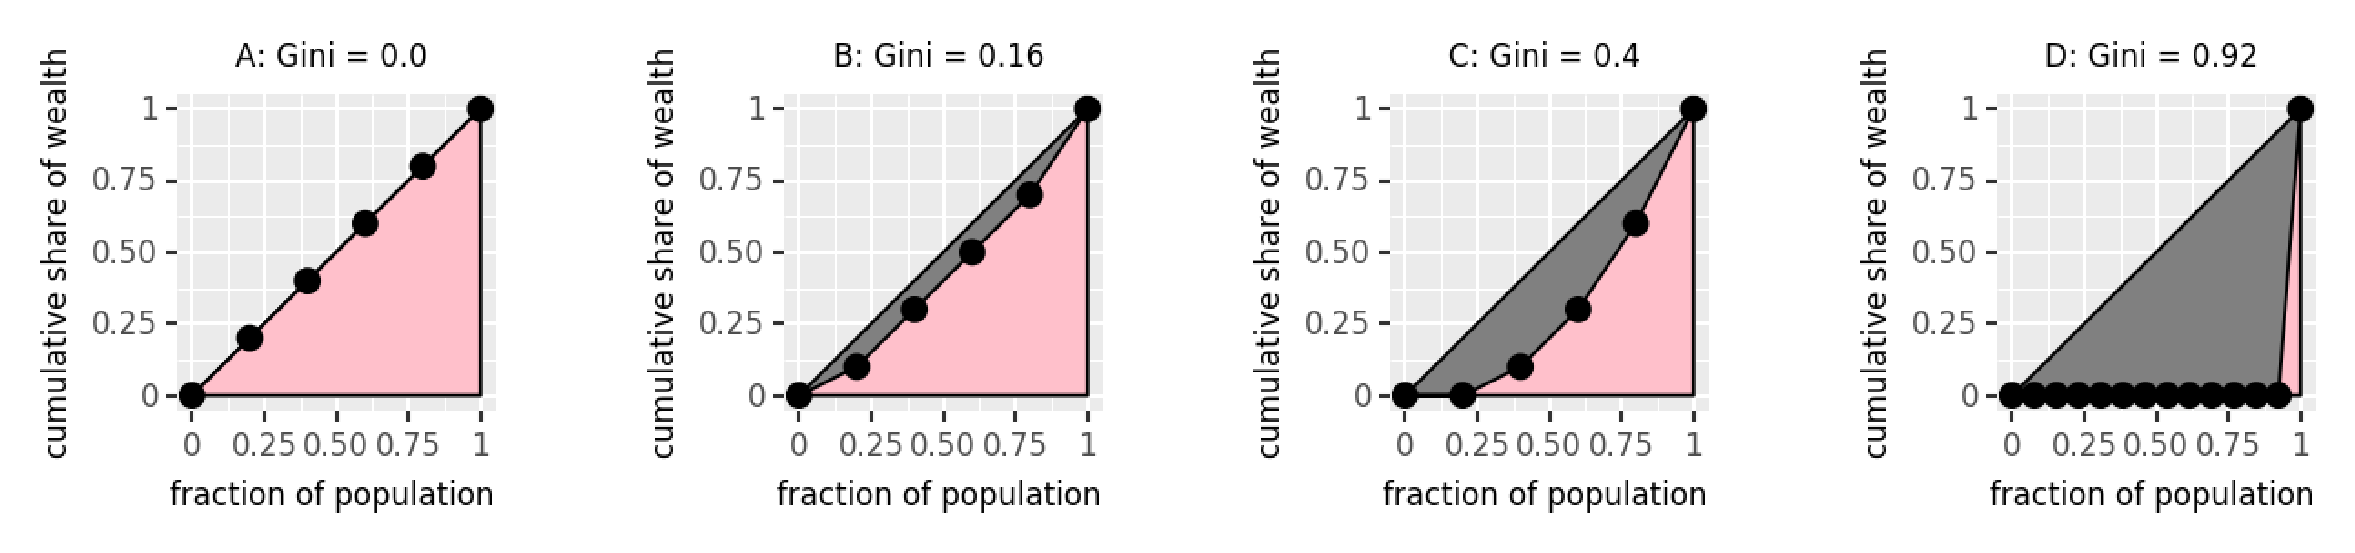

In [138]:
lorenz_curve([2,2,2,2,2],"A")
lorenz_curve([1,2,2,2,3],"B")
lorenz_curve([0,1,2,3,4],"C")
lorenz_curve([0,0,0,0,4],"D")
show_lorenz_plots(["A","B","C","D"])


The four histograms below show  the same examples of distributions with their Gini coefficients.

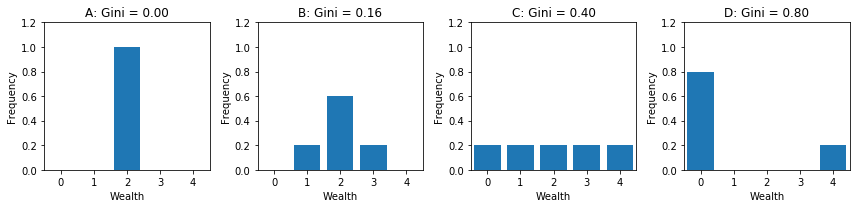

In [21]:
plt.figure(figsize=(12,3))
plt.subplot(1,4,1)
gini_hist([2,2,2,2,2], "A")
plt.subplot(1,4,2)
gini_hist([1,2,2,2,3], "B")
plt.subplot(1,4,3)
gini_hist([0,1,2,3,4], "C")
plt.subplot(1,4,4)
gini_hist([4] + [0]*4, "D")
plt.tight_layout()

#### Short Answer 1
The Gini coefficient measures inequality. Which of the four above is the most equal distribution of wealth, and why? Does the Gini coefficient confirm your reasoning?

Consider the plot B above. It shows 5 people. Three of the people have 2 units of wealth. If we take all 2 units from one of the people with 2 units of wealth, and give them to another person with 2 units of wealth, which of the above plots would we end up with? Would you expect that process to make the wealth distribution more equal or more unequal? Does the change in Gini coefficient confirm your intuition?

🤔 Your answer here:

## Section 4: Experiment
We will now reproduce some of the figures from the Salganik, Dodds, and Watts experiment [SDW2006]. The main research questions were 1. whether social influence had an effect on the inequality of song success as measured by number of downloads, and 2. whether social influence had an effect on the unpredictability of a song's success, as measured by number of downloads.

### 4.1 Descriptive Statistics

In [ ]:
# Helper functions

# Count downloads for each song
def count_song_stats(df_downloads):
    # Create list of song_id values present in input
    song_ids = sorted(set(df_downloads["song_id"]))
    # Create DataFrame for songs
    df_songs = pd.DataFrame({"song_id":song_ids}) \
        .set_index("song_id")
    df_songs["download_count"] = [
        df_downloads[df_downloads["song_id"] == cur_song]["download_count"].sum()
        for cur_song in df_songs.index]
    # Calculate mean over all worlds
    df_songs["mean_rating"] = np.zeros(len(df_songs.index))
    df_songs["rating_count"] = np.zeros(len(df_songs.index))
    for cur_song in df_songs.index:
        df = df_downloads[df_downloads["song_id"] == cur_song]
        df = df[~np.isnan(df["mean_rating"])]
        total_rating = float(np.dot(df["mean_rating"], df["rating_count"]))
        total_count = float(df["rating_count"].sum())
        try:
            df_songs["rating_count"] = total_count
            mean_rating = total_rating / total_count
            df_songs.loc[cur_song, "mean_rating"] = mean_rating
        except ZeroDivisionError:
            df_songs.loc[cur_song, "mean_rating"] = np.NaN
    return df_songs

# Count downloads for each world
def count_world_stats(df_downloads):
    # Create list of world_id values present in input
    world_ids = sorted(set(df_downloads["world_id"]))
    # Create DataFrame for worlds
    df_worlds = pd.DataFrame({"world_id":world_ids}) \
        .set_index("world_id")
    # Count downloads for each world
    df_worlds["download_count"] = [
        df_downloads[df_downloads["world_id"] == cur_world]["download_count"].sum()
        for cur_world in df_worlds.index
    ]
    # Calculate mean over all songs
    df_worlds["rating_count"] = np.zeros(len(df_worlds.index))
    df_worlds["mean_rating"] = np.zeros(len(df_worlds.index))
    for cur_world in df_worlds.index:
        df = df_downloads[df_downloads["world_id"] == cur_world]
        df = df[~np.isnan(df["mean_rating"])]
        total_rating = float(np.dot(df["mean_rating"], df["rating_count"]))
        total_count = float(df["rating_count"].sum())
        df_worlds["rating_count"] = total_count
        try:
            mean_rating = total_rating / total_count
            df_worlds.loc[cur_world, "mean_rating"] = mean_rating
        except ZeroDivisionError:
            df_worlds.loc[cur_world, "mean_rating"] = np.NaN            
    return df_worlds


In [ ]:
# Before starting the analysis, we need to choose which quantity to analyze.
analysis_column = "download_count"

After calculating statistics about the data set, we can use a histogram to visualize how frequent different values are. The x-axis represents the download count (or other analysis variable selected above). The height of each bar represents how many items have a download count in the corresponding range.

In [ ]:
# Plot histogram of download counts
df_songs = count_song_stats(df_downloads)
df_worlds = count_world_stats(df_downloads)
h = plt.hist([ x for x in df_songs[analysis_column] if not np.isnan(x)], bins=20)
plt.title("{} observations".format(sum(h[0])))
plt.xlabel(analysis_column)
plt.ylabel("Frequency")


#### Short Answer 2
Write a few sentences describing the shape of the above download distribution.
Are some download counts more common than others?
Where does the most frequent download count (tallest bar) fall between the highest and the lowest?
Is the most popular song many times more popular (in terms of downloads) than typical songs or about the same?

🤔 Your answer here:


### 4.2 Gini Coefficient
Now we can find the Gini coefficient in each world to compare the inequality in social influence worlds (1-8) to the non-influence world (9). The vertical black bars represent the uncertainty in the calculated value.

In [ ]:
# Calculate and plot the gini coefficient for each world
df_world_gini = get_world_gini(df_world_song)
plt.figure(figsize=(4, 4))
plt.grid()
plt.bar(df_world_gini.index, df_world_gini["gini"], yerr=df_world_gini["gini_se"])
plt.xticks(df_world_gini.index, df_world_gini.index)
plt.xlabel("World")
plt.ylabel("Gini coefficient")


#### Short Answer 3
Write a few sentences interpreting the figure above, considering the following questions. How does the Gini coefficient of the independent world compare to the social influence worlds? What does that difference
mean in the context of the experiment?

🤔 Your answer here:

### 4.3 Market Share
The market share represents the popularity of an artifact. It can be calculated from several possible quantities, including ratings and downloads.

The helper functions below calculate the market share as well as the rank of an artifact's market share compared to all others.

In [ ]:
# Helper functions

# Calculate market shares
def get_market_share(df_world_song):
    '''Return a DataFrame containing song_id, world_id, and market_share columns.'''
    # Create a copy of the input to return
    df = df_world_song.copy()
    # Count the total downloads for each world
    df_worlds = count_world_stats(df)
    world_ids = df_worlds.index
    # Calculate the market share
    if analysis_column == 'mean_rating':
        df["market_share"] = [
            float(df.loc[i, "mean_rating"] * df.loc[i, "rating_count"]) \
                / float(df_worlds.loc[df.loc[i, "world_id"]]["rating_count"])
                / float(df_worlds.loc[df.loc[i, "world_id"]]["mean_rating"])
            for i in df.index]
    elif analysis_column == 'download_count':
        df["market_share"] = [
            float(df.loc[i, "download_count"]) \
                / float(df_worlds.loc[df.loc[i, "world_id"], "download_count"])
            for i in df.index]
    return df

# Calculate market share and rank for each song/world
def get_market_rank(df_world_song):
    # Get market share
    df_world_song["market_share"] = get_market_share(df_world_song)["market_share"]
    # Copy market share, and convert to rank one world at a time
    ranks = []
    for cur_world in sorted(set(df_world_song["world_id"])):
        df = df_world_song[df_world_song["world_id"] == cur_world].copy()
        df["market_rank"] = df["market_share"].rank(ascending=False)
        # Store results for this world in an array
        ranks.append(df)
    # Concatenate results for all worlds
    df_world_song['market_rank'] = pd.concat(ranks)['market_rank']
    # Remove nan entries
    nan_songs = list(df_world_song[np.isnan(df_world_song["market_share"])]["song_id"])
    df = df_world_song
    for cur_song in nan_songs:
        df = df[df["song_id"] != cur_song]
    return df

We plot the market shares (and ranks) of artifacts in social influence worlds as a function of their market shares (and ranks) in the independent world.

In [ ]:
# Get market share and rank
df_market = get_market_rank(df_world_song)

# Create list of dependent worlds
world_ids = sorted(set(df_world_song["world_id"]))
dependent_worlds = [x for x in world_ids if x != data.independent_world]

# Create a figure
plt.figure(figsize(8,4))
# Plot social influence market share vs independent market share
# Create subplots and use first
plt.subplot(1,2,1)
for cur_world in dependent_worlds:
    plt.plot(
        df_market[df_market["world_id"] == data.independent_world]['market_share'],
        df_market[df_market["world_id"] == cur_world]['market_share'], '.b')
plt.xlabel("Market share (Indep.)")
plt.ylabel("Market share (Social)")
# Plot social rank vs indpendent rank in second subplot
plt.subplot(1,2,2)
for cur_world in dependent_worlds:
    plt.plot(
        df_market[df_market["world_id"] == data.independent_world]['market_rank'],
        df_market[df_market["world_id"] == cur_world]['market_rank'], '.b')
plt.xlabel("Market rank (Indep.)")
plt.ylabel("Market rank (Social)")
plt.tight_layout()

#### Short Answer 4
We can consider the market share in the indpendent world a measure of song quality. Write a few sentences answering the following questions.
Why might the market share of a song be correlated between different worlds?
Why might a song have different market shares in different worlds?
How would you expect the plots to look if there was no social influence?
If there was strong social influence?
In terms of quality, which types of songs have the most and least variance in their market share?


🤔 Your answer here:

### 4.4 Unpredictability
In this section, we investigate whether the success of cultural artifacts is more or less predictable when there is social influence.
We can compare a given artifact's popularity in different social influence worlds to determine the unpredictability.
For the independent case, we have to randomly divide the independent world into multiple worlds and compare between those.

The helper functions below calculate the unpredictability of artifacts in both social influence and indpendent worlds.

In [ ]:
# Helper functions

def find_unpredictability(df_downloads):
    '''Return a DataFrame indexed by song_id with an `unpredictability` column.'''
    # Create the DataFrame and index from the provided download data
    song_ids = sorted(set(df_downloads["song_id"]))
    world_ids = sorted(set(df_downloads["world_id"]))
    df = pd.DataFrame({"song_id": song_ids}) \
        .set_index("song_id")
    # Get market share of each song in each world
    df_market = get_market_share(df_downloads)
    # Calculate and return the unpredictability based on equation in SDW2006
    df["unpredictability"] = [
        sum([
            sum([
                abs(
                    df_market[
                        (df_market["song_id"] == cur_song)
                        & (df_market["world_id"] == world_j)
                    ]["market_share"].sum()
                    - df_market[
                        (df_market["song_id"] == cur_song)
                        & (df_market["world_id"] == world_k)
                    ]["market_share"].sum()
                ) / spspec.comb(len(world_ids), 2)
                for k, world_k in enumerate(world_ids[j+1:])])
            for j, world_j in enumerate(world_ids)])
        for cur_song in df.index]
    return df

def compare_unpredictability(df_world_song):
    # Calculate unpredictability in social influence worlds
    df_songs = count_song_stats(df_world_song)
    df_social = df_world_song[df_world_song["world_id"] != data.independent_world]
    df_songs["unpredictability"] = find_unpredictability(df_social)["unpredictability"]
    # Calculate unpredictability in independent world
    unpredictability = []
    num_iter = 50
    for i in range(num_iter):
        df_indep_dl = data.sample_independent()
        u_i = find_unpredictability(df_indep_dl)["unpredictability"]
        unpredictability.append(u_i) 
    # Average results
    # Elements are pandas Series objects, which can be added to each other
    u = np.sum(unpredictability, axis=0) / float(num_iter)
    # Add to the song DataFrame
    df_songs["unpredictability_indep"] = u
    return df_songs

The plot below visualizes the unpredictability in social influence worlds vs independent worlds.

In [ ]:
# Plot the unpredictability for social and independent worlds
df_songs = compare_unpredictability(df_world_song)
u_social = df_songs["unpredictability"].sum() / data.num_songs
u_indep = df_songs["unpredictability_indep"].sum() / data.num_songs
plt.figure(figsize=(6,4))
plt.bar([1, 2], [u_social, u_indep])
plt.xticks([1,2], ["Social", "Independent"])
plt.ylim([0, max([u_social, u_indep])*2])
plt.xlabel("World")
plt.ylabel("Unpredictability")

#### Short Answer 5
Write a few sentences interpreting the above plot, considering the following questions.
How could social influence have an effect on the predictability of an artifact's success?
Would you expect social influence to make success more or less predictable? Why?

🤔 Your answer here:

## Section 5: Reflection

#### Reflection Question 1
Consider the distribution plotted in the following cell. By comparing it to the plots in [Section 3](#Section-3%3A-Gini-Coefficient) and their Gini coefficients, what range would you expect the Gini coefficient for this plot to fall into, and why?

In [ ]:
plt.figure(figsize=(3,3))
x = [0,0,1,2,4]
plt.hist(x, rwidth=0.8, density=True, bins=np.arange(-0.5,5.5,1))
plt.ylim([0,1.2]); plt.xlim([-0.5,4.5]); plt.xticks(range(0,5))
xlabel("Wealth"); ylabel("Frequency")
plt.tight_layout()

🤔 Your answer here:

#### Reflection Question 2
Assuming the results of the (SDW2006) are true in general, and social influence results in higher unpredicatbility and inequality, write a paragraph addressing the following questions.
If you are designing a site to stream music and you want to make sure the popularity of a song accuratley reflects its quality, would you include information about download counts, ratings, etc. when the song appears? Why or why not?
Would you include that information if you wanted the site to have
"rock stars" who are much more popular than their peers? Why or why not?
If you wanted users to be able to quickly find good music, would you include information about download counts and ratings? Why or why not?


🤔 Your answer here:

#### Reflection Question 3
Now that you've reproduced the analysis from (SDW2006), it's your turn! You will be running your own online experiment to measure the effects of social influence. Before starting an experiment, it's important to think about how many participants you will need in order to find what you're looking for. This is called power analysis. The smaller the effect you're trying to find, the more participants you will need.

In (SDW2006) experiment 1, songs were shown in a grid, creating a weak social influence. In this case, not very many participants are necessary to see the unpredictability effect, but we have calculated that at least 900 participants in each world are necessary to observe an effect on inequality. In experiment 2, the songs were shown in a list, creating a strong social influence effect. In this case, only 450 participants are necessary in each world.

Write a paragraph answering the following questions.
If the social influence condition in your experiment has the same effect size as (SDW2006) experiment 2, and you have 4 worlds, how many participants will you need in total?
If your number of participants is limited, you want to make sure the effect size is as strong as possible. Should you use a grid layout (as in experiment 1) or a list layout (as in experiment 2)?
Can you think of any other ways you might create a larger social influence effect?

🤔 Your answer here:

## References

(SDW2006) Salganik, M. J., Dodds, P. S., & Watts, D. J. (2006). Experimental study of inequality and unpredictability in an artificial cultural market. _Science_, 311(5762), 854-856.